<a href="https://colab.research.google.com/github/chenyq121/760-2022S2/blob/main/optunaBaselineCNN_HL_2bin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 4.7 MB/s 
     |████████████████████████████████| 81 kB 11.7 MB/s 
     |████████████████████████████████| 209 kB 63.0 MB/s 
     |████████████████████████████████| 78 kB 8.4 MB/s 
     |████████████████████████████████| 112 kB 48.0 MB/s 
     |████████████████████████████████| 49 kB 7.0 MB/s 
     |████████████████████████████████| 147 kB 69.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=06013f06c9487ca23b0eaee16e35f15fc9e6f9e4f251d64e6bd81cadf9b47818
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
#mounted to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import os

# os.chdir('/content/drive/Shareddrives/760/Data/')
# os.getcwd()
# os.listdir('.')

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import gc
import torch
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision
import os
import torch.utils.data
import matplotlib.pyplot as plt
from PIL import Image
import optuna

# data processing 
class ClassifyDataset(torch.utils.data.Dataset):
    def __init__(self,root_path,data_file,img_size=120):
        self.data_files=np.loadtxt(data_file,dtype=np.str)
        self.root_path=root_path
        self.class_list=os.listdir(
            os.path.join(root_path,'')
        )
        self.transforms=torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize((img_size,img_size)), 
                torchvision.transforms.Grayscale(num_output_channels=1),
                torchvision.transforms.ToTensor()
            ]
        )

    def __getitem__(self, item):
        data_file=self.data_files[item]
        data_file=os.path.join(self.root_path,data_file)
        # get the image
        img=Image.open(data_file).convert('RGB') # three channels
        # get the label(in this case the label is the folder name)
        tmp=data_file.split('/')
        label_name=tmp[-2]
        #print("label_name:",label_name)
        label=self.class_list.index(label_name)
        #print("label:",label)
        # prepare the images and label
        img=self.transforms(img)
        label=torch.tensor(label)
        #print("torch_label:",label)
        return img,label

    def __len__(self):
        return len(self.data_files)



# model building
class CNet(nn.Module):
    def __init__(self,num_classes=21, n_layer = 1, kernel_size = 1):
        super(CNet,self).__init__()
        self.convList = nn.ModuleList()

        for i in range(1, n_layer):
          input = 2 ** (i + 3)
          output = 2 ** (i + 4)
          if i == 1:
            input = 1
            
          self.convList.append(
              nn.Sequential(
                #input, output, kernel size, step, padding
                nn.Conv2d(input, output, kernel_size, 1, padding=1),
                nn.BatchNorm2d(output), # batch normalization
                nn.ReLU()
              )
          )

        self.pool = nn.AvgPool2d(2, 2)
        self.fclayer=nn.Sequential(
                nn.Linear(2 * input, 2 * output),
                nn.ReLU(),
                nn.Linear(2 * output, num_classes)
        )
        self.avg_pool=nn.AdaptiveAvgPool2d((1, 1))
        self.softmax=nn.Softmax(dim=1)

    def forward(self,x):
      x = self.convList[0](x)
      x = self.pool(x)
      for conv in self.convList[1:]:
        x = conv(x)
        x = self.pool(x)
      x = self.avg_pool(x)
      x = torch.flatten(x,1)
      logits=self.fclayer(x)
      prob=self.softmax(logits)
      return logits,prob

    


# training
def training(model,root_path,train_data_file,batch_size,lr, epoch_num):
    # get training data
    train_dataset=ClassifyDataset(root_path,train_data_file)
    train_dataloader=torch.utils.data.DataLoader(train_dataset,batch_size,shuffle=True,num_workers=0)


    # loss function and optimizer
    criterion=nn.CrossEntropyLoss()
    optimizer=torch.optim.Adam(model.parameters(),lr=lr)

    total_loss=[]

    for epoch in range(epoch_num):
        # print(epoch+1,"epoch:")
        total_train_loss=0
        res_num=len(train_dataset)
        for data in train_dataloader:

            if (res_num - batch_size) > 0:
                cnt=batch_size
                res_num = res_num - batch_size
            else:
                cnt=res_num
                res_num = 0

            ## GPU
            train_img,train_label=data
            train_img=train_img.to(device)
            train_label=train_label.to(device)

            ## get loss result
            train_logits,train_prob=model(train_img)
            train_loss=criterion.forward(train_logits,train_label)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            
            train_pred=torch.argmax(train_prob,dim=1)
            train_acc=(train_pred==train_label).float()
            train_acc=torch.mean(train_acc)
            # print('loss:',train_loss.item(), 'acc:', train_acc.item())
            total_train_loss=total_train_loss+train_loss*cnt

        total_train_loss=total_train_loss/len(train_dataset)
        total_loss.append(total_train_loss.item())

    state_dict=model.state_dict()
    torch.save(state_dict,'/content/drive/MyDrive/model/60-20-20model_gHL2bin_120-optune.pth')

    # plt.xlabel('epoch')
    # plt.ylabel('loss')
    # plt.plot(total_loss)
    # plt.legend(['train loss'])
    # plt.show()

# test
def test(model,root_path,test_data_file):
    state_dict = torch.load('/content/drive/MyDrive/model/60-20-20model_gHL2bin_120-optune.pth')
    model.load_state_dict(state_dict)
    model.eval() # no BatchNormalization and Dropout

    test_dataset=ClassifyDataset(root_path,test_data_file)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=True, num_workers=0)

    criterion = nn.CrossEntropyLoss()

    res_num=len(test_dataset)
    total_acc=0

    for data in test_dataloader:
      with torch.no_grad():

        if (res_num-batch_size)>0:
            cnt=batch_size
            res_num = res_num - batch_size
        else:
            cnt=res_num
            res_num = 0

        test_img,test_label=data
        test_img=test_img.to(device)
        test_label=test_label.to(device)

        test_logits,test_prob=model(test_img)
        test_loss=criterion.forward(test_logits,test_label)

        # Top1 accuracy: correct number/total number
        test_pred = torch.argmax(test_prob, dim=1)
        # print(test_pred)
        # print(test_label)
        test_acc = (test_pred == test_label).float()
        # print(test_acc)
        test_acc = torch.mean(test_acc)
        total_acc = total_acc + test_acc * cnt

        # print('loss:',test_loss.item(), 'top1:',test_acc.item() )

    total_acc=total_acc/len(test_dataset)
    return total_acc.item()
    # print('\n')
    # print('Top-1 Accuracy:',total_acc.item())


def objective(trial):

    params = {
              'n_layer': trial.suggest_int('n_layer', 3, 5, step = 2),
              'kernel_size': trial.suggest_int('kernel_size', 3, 5, step = 2),
              'lr': trial.suggest_categorical('lr', [0.1, 0.01, 0.001]),
              'epoch_num': trial.suggest_categorical('epoch_num', [10, 50, 100])
              }

    # get model and put model on the device
    model=CNet(n_layer = params['n_layer'], kernel_size = params['kernel_size'])
    model = model.to(device)

    training(model,root_path,train_data_file,batch_size,lr = params['lr'], epoch_num = params['epoch_num'])
    # torch.cuda.empty_cache()
    return test(model,root_path,test_data_file)




In [ ]:
# optuna hyperparameter tuning
if __name__ == '__main__':

    root_path = r'/content/drive/MyDrive/original/'
    train_data_file=r'/content/drive/MyDrive/original/HLtrain.txt'
    test_data_file=r'/content/drive/MyDrive/original/HLvalidate.txt'
    batch_size=64
    device = torch.device("cuda:0")
    
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
    study.optimize(objective, n_trials=40)

[I 2022-10-01 04:35:17,937] A new study created in memory with name: no-name-846089d1-b274-458b-84e5-b2918960053b
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app
[I 2022-10-01 05:14:42,853] Trial 0 finished with value: 0.5296803712844849 and parameters: {'n_layer': 5, 'kernel_size': 3, 'lr': 0.001, 'epoch_num': 10}. Best is trial 0 with value: 0.5296803712844849.
[I 2022-10-01 05:31:01,861] Trial 1 finished with value: 0.49885842204093933 and parameters: {'n_layer': 5, 'kernel_size': 5, 'lr': 0.001, 'epoch_num': 50}. Best is trial 0 with value: 0.5296803712844849.
[I 202

KeyboardInterrupt: ignored

In [ ]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

n_layer: 5
kernel_size: 5
lr: 0.001
epoch_num: 50


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision
import os
import torch.utils.data
import matplotlib.pyplot as plt
from PIL import Image
import optuna

# data processing 
class ClassifyDataset(torch.utils.data.Dataset):
    def __init__(self,root_path,data_file,img_size=120):
        self.data_files=np.loadtxt(data_file,dtype=np.str)
        self.root_path=root_path
        self.class_list=os.listdir(
            os.path.join(root_path,'')
        )
        self.transforms=torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize((img_size,img_size)), 
                torchvision.transforms.Grayscale(num_output_channels=1),
                torchvision.transforms.ToTensor()
            ]
        )

    def __getitem__(self, item):
        data_file=self.data_files[item]
        data_file=os.path.join(self.root_path,data_file)
        # get the image
        img=Image.open(data_file).convert('RGB') # three channels
        # get the label(in this case the label is the folder name)
        tmp=data_file.split('/')
        label_name=tmp[-2]
        #print("label_name:",label_name)
        label=self.class_list.index(label_name)
        #print("label:",label)
        # prepare the images and label
        img=self.transforms(img)
        label=torch.tensor(label)
        #print("torch_label:",label)
        return img,label

    def __len__(self):
        return len(self.data_files)



# model building
class CNet(nn.Module):
    def __init__(self,num_classes=21, n_layer = 1, kernel_size = 1):
        super(CNet,self).__init__()
        self.convList = nn.ModuleList()

        for i in range(1, n_layer):
          input = 2 ** (i + 3)
          output = 2 ** (i + 4)
          if i == 1:
            input = 1
            
          self.convList.append(
              nn.Sequential(
                #input, output, kernel size, step, padding
                nn.Conv2d(input, output, kernel_size, 1, padding=1),
                nn.BatchNorm2d(output), # batch normalization
                nn.ReLU()
              )
          )

        self.pool = nn.AvgPool2d(2, 2)
        self.fclayer=nn.Sequential(
                nn.Linear(2 * input, 2 * output),
                nn.ReLU(),
                nn.Linear(2 * output, num_classes)
        )
        self.avg_pool=nn.AdaptiveAvgPool2d((1, 1))
        self.softmax=nn.Softmax(dim=1)

    def forward(self,x):
      x = self.convList[0](x)
      x = self.pool(x)
      for conv in self.convList[1:]:
        x = conv(x)
        x = self.pool(x)
      x = self.avg_pool(x)
      x = torch.flatten(x,1)
      logits=self.fclayer(x)
      prob=self.softmax(logits)
      return logits,prob

    


# training
def training(model,root_path,train_data_file,batch_size,lr, epoch_num):
    # get training data
    train_dataset=ClassifyDataset(root_path,train_data_file)
    train_dataloader=torch.utils.data.DataLoader(train_dataset,batch_size,shuffle=True,num_workers=0)


    # loss function and optimizer
    criterion=nn.CrossEntropyLoss()
    optimizer=torch.optim.Adam(model.parameters(),lr=lr)

    total_loss=[]

    for epoch in range(epoch_num):
        print(epoch+1,"epoch:")
        total_train_loss=0
        res_num=len(train_dataset)
        for data in train_dataloader:

            if (res_num - batch_size) > 0:
                cnt=batch_size
                res_num = res_num - batch_size
            else:
                cnt=res_num
                res_num = 0

            ## GPU
            train_img,train_label=data
            train_img=train_img.to(device)
            train_label=train_label.to(device)

            ## get loss result
            train_logits,train_prob=model(train_img)
            train_loss=criterion.forward(train_logits,train_label)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            
            train_pred=torch.argmax(train_prob,dim=1)
            train_acc=(train_pred==train_label).float()
            train_acc=torch.mean(train_acc)
            # print('loss:',train_loss.item(), 'acc:', train_acc.item())
            total_train_loss=total_train_loss+train_loss*cnt

        total_train_loss=total_train_loss/len(train_dataset)
        total_loss.append(total_train_loss.item())

    state_dict=model.state_dict()
    torch.save(state_dict,'/content/drive/MyDrive/model/60-20-20model_HL2bin_120-optune.pth')

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(total_loss)
    plt.legend(['train loss'])
    plt.show()

# test
def test(model,root_path,test_data_file):
    state_dict = torch.load('/content/drive/MyDrive/model/60-20-20model_HL2bin_120-optune.pth')
    model.load_state_dict(state_dict)
    model.eval() # no BatchNormalization and Dropout

    test_dataset=ClassifyDataset(root_path,test_data_file)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=True, num_workers=0)

    criterion = nn.CrossEntropyLoss()

    res_num=len(test_dataset)
    total_acc=0

    for data in test_dataloader:
      with torch.no_grad():

        if (res_num-batch_size)>0:
            cnt=batch_size
            res_num = res_num - batch_size
        else:
            cnt=res_num
            res_num = 0

        test_img,test_label=data
        test_img=test_img.to(device)
        test_label=test_label.to(device)

        test_logits,test_prob=model(test_img)
        test_loss=criterion.forward(test_logits,test_label)

        # Top1 accuracy: correct number/total number
        test_pred = torch.argmax(test_prob, dim=1)
        # print(test_pred)
        # print(test_label)
        test_acc = (test_pred == test_label).float()
        # print(test_acc)
        test_acc = torch.mean(test_acc)
        total_acc = total_acc + test_acc * cnt

        print('loss:',test_loss.item(), 'top1:',test_acc.item() )

    total_acc=total_acc/len(test_dataset)
    # return total_acc.item()
    print('\n')
    print('Top-1 Accuracy:',total_acc.item())


# def objective(trial):

#     params = {
#               'n_layer': trial.suggest_int('n_layer', 3, 5, step = 2),
#               'kernel_size': trial.suggest_int('kernel_size', 3, 5, step = 2),
#               'lr': trial.suggest_categorical('lr', [0.1, 0.01, 0.001]),
#               'epoch_num': trial.suggest_categorical('epoch_num', [10, 50, 100])
#               }

#     # get model and put model on the device
#     model=CNet(n_layer = params['n_layer'], kernel_size = params['kernel_size'])
#     model = model.to(device)

#     training(model,root_path,train_data_file,batch_size,lr = params['lr'], epoch_num = params['epoch_num'])
#     # torch.cuda.empty_cache()
#     return test(model,root_path,test_data_file)




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


1 epoch:
2 epoch:
3 epoch:
4 epoch:
5 epoch:
6 epoch:
7 epoch:
8 epoch:
9 epoch:
10 epoch:
11 epoch:
12 epoch:
13 epoch:
14 epoch:
15 epoch:
16 epoch:
17 epoch:
18 epoch:
19 epoch:
20 epoch:
21 epoch:
22 epoch:
23 epoch:
24 epoch:
25 epoch:
26 epoch:
27 epoch:
28 epoch:
29 epoch:
30 epoch:
31 epoch:
32 epoch:
33 epoch:
34 epoch:
35 epoch:
36 epoch:
37 epoch:
38 epoch:
39 epoch:
40 epoch:
41 epoch:
42 epoch:
43 epoch:
44 epoch:
45 epoch:
46 epoch:
47 epoch:
48 epoch:
49 epoch:
50 epoch:


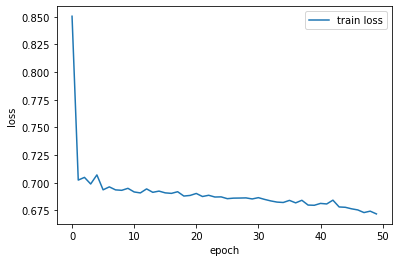

loss: 0.6612515449523926 top1: 0.65625
loss: 0.6938987970352173 top1: 0.53125
loss: 0.7157400250434875 top1: 0.484375
loss: 0.7181747555732727 top1: 0.46875
loss: 0.7378650307655334 top1: 0.453125
loss: 0.6992539763450623 top1: 0.53125
loss: 0.7060288190841675 top1: 0.53125
loss: 0.7172825336456299 top1: 0.484375
loss: 0.6938574910163879 top1: 0.53125
loss: 0.6924389004707336 top1: 0.578125
loss: 0.7084363698959351 top1: 0.484375
loss: 0.7869442701339722 top1: 0.34375
loss: 0.6968803405761719 top1: 0.53125
loss: 0.7324434518814087 top1: 0.4318181872367859


Top-1 Accuracy: 0.5045661926269531


In [ ]:
# main function
if __name__ == '__main__':

    root_path = r'/content/drive/MyDrive/original/'
    train_data_file=r'/content/drive/MyDrive/original/HLtrainval.txt'
    test_data_file=r'/content/drive/MyDrive/original/HLtest.txt'
    batch_size=64
    #lr=best_trial.params['lr'] #learning rate
    #epoch_num=best_trial.params['epoch_num']
    #layers=best_trial.params['n_layer']
    #kernals=best_trial.params['kernel_size']
    lr=0.001 #learning rate
    epoch_num=50
    layers=5
    kernals=5
    device='cuda:0'
    # get model and put model on the device
    model=CNet(n_layer = layers, kernel_size = kernals)
    model.to(device)

    training(model,root_path,train_data_file,batch_size,lr,epoch_num)
    torch.cuda.empty_cache()
    test(model,root_path,test_data_file)

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()


2750